In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [2]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


In [3]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


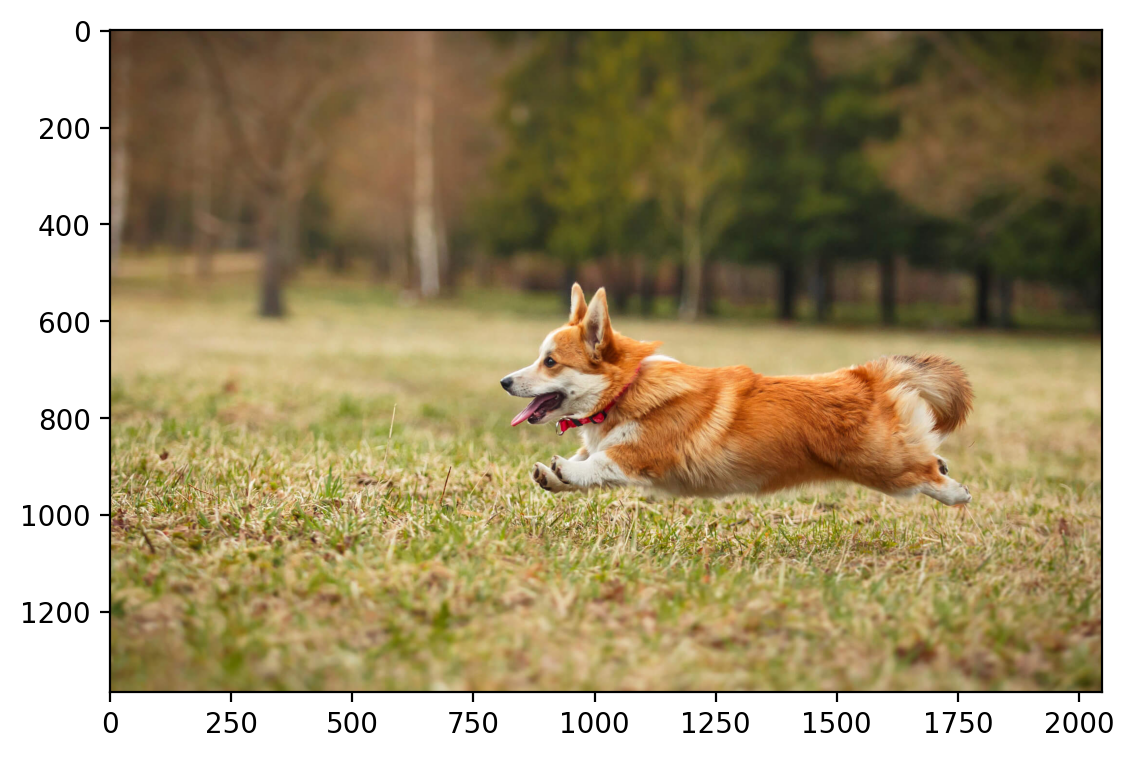

In [4]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())


In [5]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [6]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [7]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [8]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
crop.shape

torch.Size([3, 300, 300])

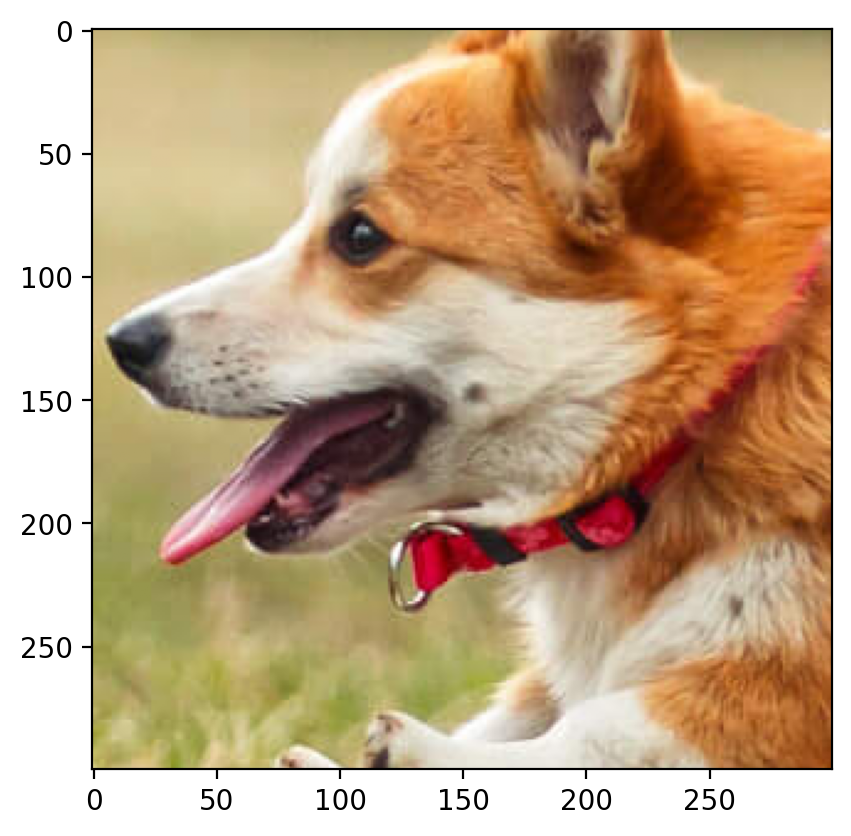

In [9]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())


In [10]:
crop = crop.to(device)


In [11]:
# Get the dimensions of the image tensor
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 300 300


In [12]:
num_channels, height, width = 2, 3, 4

    
# Create a 2D grid of (x,y) coordinates
w_coords = torch.arange(width).repeat(height, 1)
h_coords = torch.arange(height).repeat(width, 1).t()
w_coords = w_coords.reshape(-1)
h_coords = h_coords.reshape(-1)

# Combine the x and y coordinates into a single tensor
X = torch.stack([h_coords, w_coords], dim=1).float()

In [13]:
X.shape

torch.Size([12, 2])

In [14]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    
    num_channels, height, width = img.shape
    
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [15]:
dog_X, dog_Y = create_coordinate_map(crop)

dog_X.shape, dog_Y.shape

(torch.Size([90000, 2]), torch.Size([90000, 3]))

In [16]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()

In [17]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)
    

In [18]:
net = LinearModel(2, 3)
net.to(device)


LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [19]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        
        
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [20]:
train(net, 0.01, dog_X_scaled, dog_Y, 1000)

Epoch 0 loss: 0.968414
Epoch 100 loss: 0.104663
Epoch 200 loss: 0.038212
Epoch 300 loss: 0.036829
Epoch 400 loss: 0.036823
Epoch 500 loss: 0.036823
Epoch 600 loss: 0.036823
Epoch 700 loss: 0.036823
Epoch 800 loss: 0.036823
Epoch 900 loss: 0.036823


0.036822546273469925

In [21]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")
    

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
    
    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

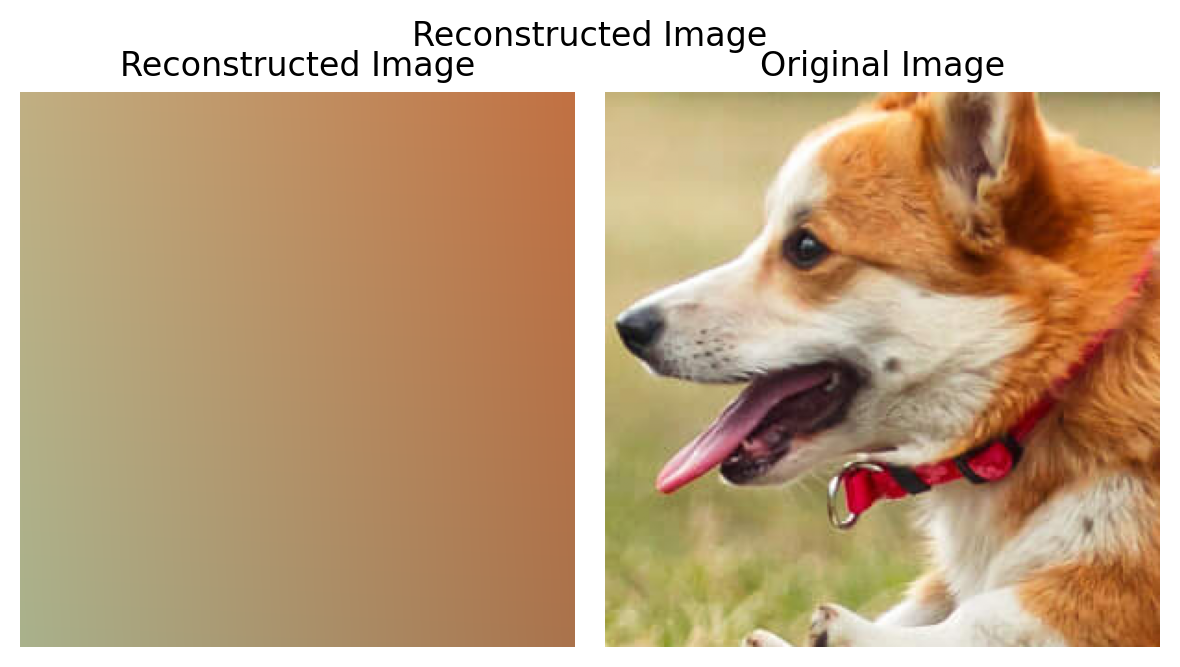

In [22]:
plot_reconstructed_and_original_image(crop, net, dog_X_scaled, title="Reconstructed Image")

In [23]:
# Use polynomial features of degree "d"

def poly_features(X, degree):
    """
    X: torch.Tensor of shape (num_samples, 2)
    degree: int
    
    return: torch.Tensor of shape (num_samples, degree * (degree + 1) / 2)
    """
    X1 = X[:, 0]
    X2 = X[:, 1]
    X1 = X1.unsqueeze(1)
    X2 = X2.unsqueeze(1)
    X = torch.cat([X1, X2], dim=1)
    poly = preprocessing.PolynomialFeatures(degree=degree)
    X = poly.fit_transform(X.cpu())
    return torch.tensor(X, dtype=torch.float32).to(device)

In [24]:
dog_X_scaled_poly = poly_features(dog_X_scaled, 50)

In [25]:
dog_X_scaled_poly.dtype, dog_X_scaled_poly.shape, dog_Y.shape, dog_Y.dtype

(torch.float32,
 torch.Size([90000, 1326]),
 torch.Size([90000, 3]),
 torch.float32)

In [26]:
net = LinearModel(dog_X_scaled_poly.shape[1], 3)
net.to(device)

train(net, 0.005, dog_X_scaled_poly, dog_Y, 1500)

Epoch 0 loss: 0.385782
Epoch 100 loss: 0.028904
Epoch 200 loss: 0.025280
Epoch 300 loss: 0.024292
Epoch 400 loss: 0.023620
Epoch 500 loss: 0.023090
Epoch 600 loss: 0.022655
Epoch 700 loss: 0.022281
Epoch 800 loss: 0.021952
Epoch 900 loss: 0.021661
Epoch 1000 loss: 0.021408
Epoch 1100 loss: 0.021173
Epoch 1200 loss: 0.020964
Epoch 1300 loss: 0.020775
Epoch 1400 loss: 0.020625


0.020452233031392097

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


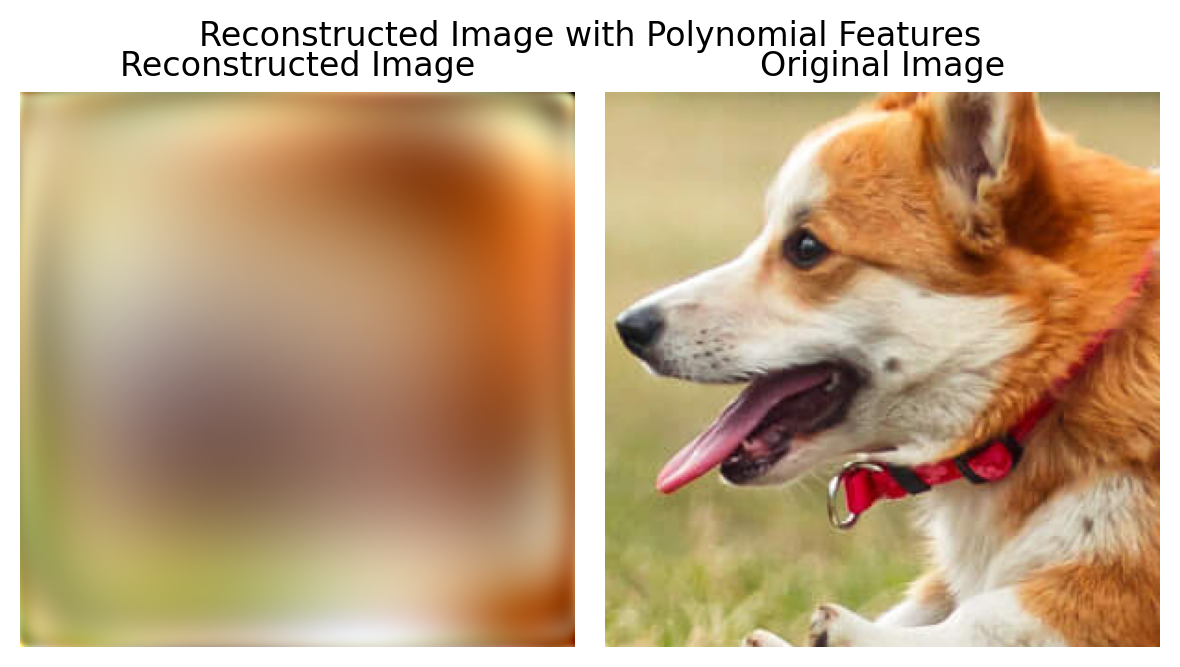

In [27]:
plot_reconstructed_and_original_image(crop, net, dog_X_scaled_poly, title="Reconstructed Image with Polynomial Features")

In [28]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)


In [40]:
X_rff = create_rff_features(dog_X_scaled, 37500, 0.008)

In [41]:
X_rff.shape

torch.Size([90000, 37500])

In [42]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff, dog_Y, 2500)

Epoch 0 loss: 0.373236
Epoch 100 loss: 0.046793
Epoch 200 loss: 0.009401
Epoch 300 loss: 0.004224
Epoch 400 loss: 0.002236
Epoch 500 loss: 0.001218
Epoch 600 loss: 0.000698
Epoch 700 loss: 0.000439
Epoch 800 loss: 0.000315
Epoch 900 loss: 0.000257
Epoch 1000 loss: 0.000231
Epoch 1100 loss: 0.000218
Epoch 1200 loss: 0.000212
Epoch 1300 loss: 0.000209
Epoch 1400 loss: 0.000207
Epoch 1500 loss: 0.000205
Epoch 1600 loss: 0.000204
Epoch 1700 loss: 0.000203
Epoch 1800 loss: 0.000202
Epoch 1900 loss: 0.000201
Epoch 2000 loss: 0.000201
Epoch 2100 loss: 0.000200
Epoch 2200 loss: 0.000199
Epoch 2300 loss: 0.000199
Epoch 2400 loss: 0.000199


0.00019816236454062164

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


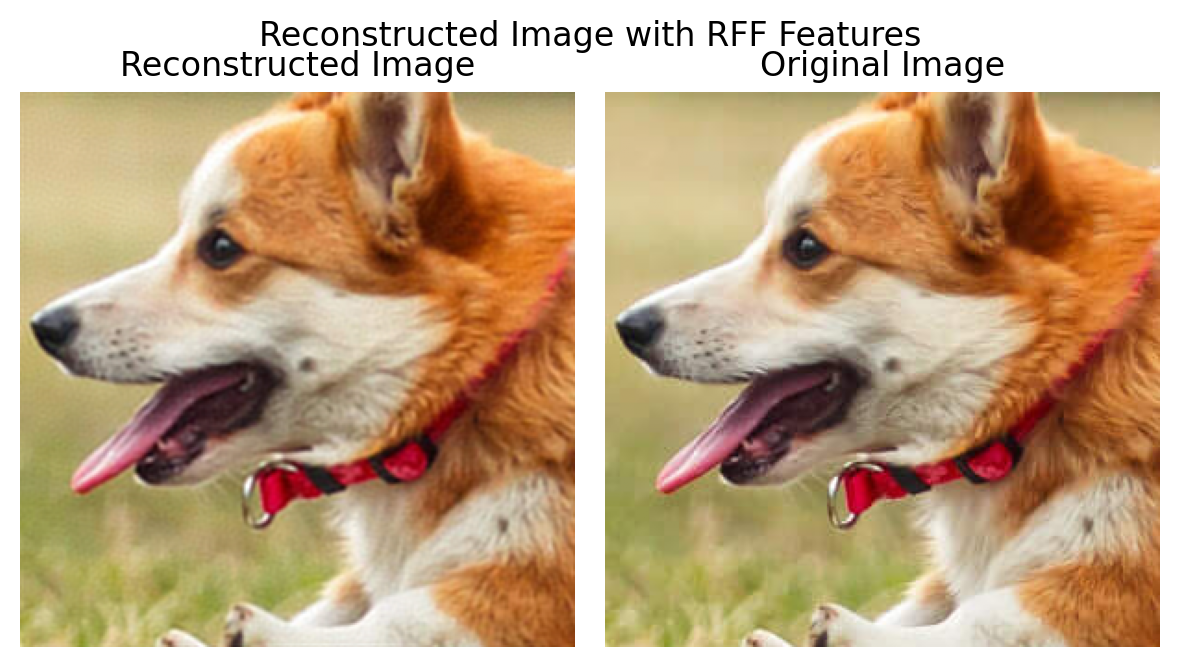

In [43]:
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")

In [50]:
# Train on a subset of the cropped image 
idx = torch.randperm(dog_X_scaled.shape[0])[:10000]

X_rff_subset = X_rff[idx]
y_subset = dog_Y[idx]


net = LinearModel(X_rff_subset.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff_subset, y_subset, 500)

Epoch 0 loss: 0.372553
Epoch 100 loss: 0.004028
Epoch 200 loss: 0.000298
Epoch 300 loss: 0.000057
Epoch 400 loss: 0.000014


4.303753030399093e-06

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


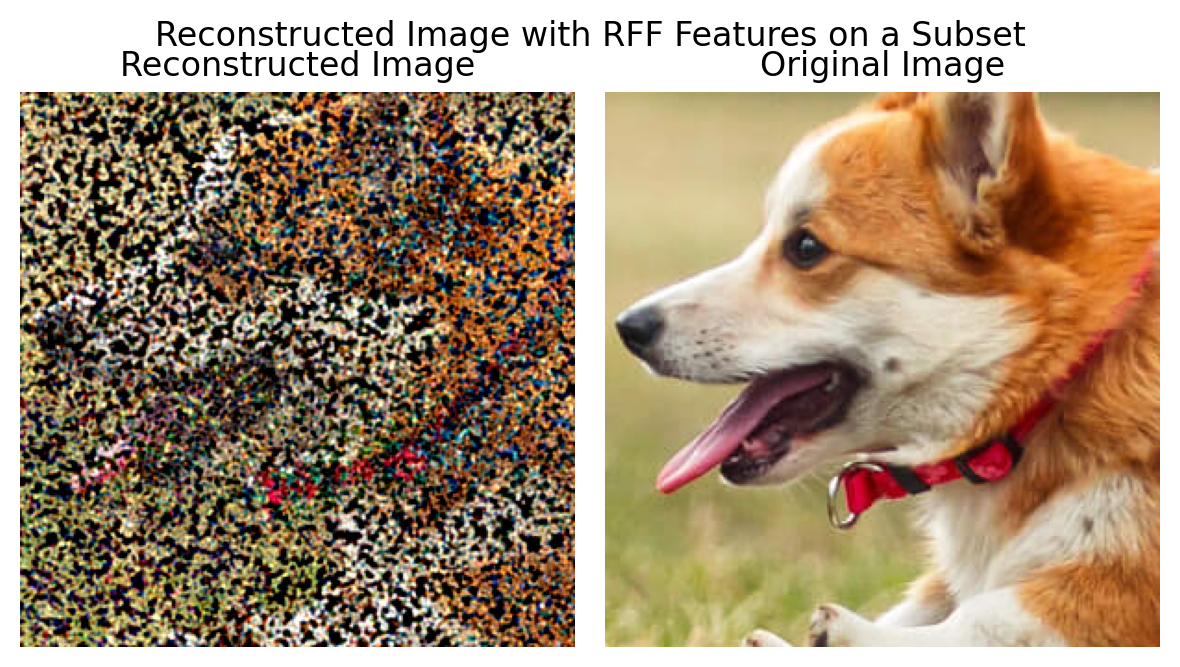

In [51]:
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features on a Subset")